# 0. Utils

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
import scipy.linalg as la
import os
from scipy.stats import mode
from scipy import stats
import statsmodels.formula.api as smf
import time
import collections as c

def to_num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s
        
# utils
rmse = lambda y, y_pred: np.sqrt(np.mean((y - y_pred) ** 2)) # n is almost the same as (n-1)
mae = lambda y, y_pred: np.mean(abs(y - y_pred)) # n is almost the same as (n-1)

# 1. Load and preprocess data

In [8]:
RES = []
print('----start loading----')
# for month in ['jan', 'feb', 'march', 'april', 'may']:
# data files from hadoop should be in the same directory with a correct name
for month in ['march', 'april', 'may']:
    file_parts = len(os.listdir(path='../data/' + month))-1
    for i in range(file_parts):
        fname = '../data/' + month + '/part-' + str(i).rjust(5, '0')
        print('{}: {:.2f}'.format(month, i/file_parts*100), end='%\r')
        with open(fname, 'r') as lines:
            count = 0
            ind_status, ind_pose = False, False
        #     numRows = 0
            for line in lines:
                tmp = line.split()
        #         print(line.split())
                if(tmp[1] == 'aw_idl/VehicleInput'):
                    res = []
                    res.extend(list(map(to_num, tmp)))
                    count += 1
        #             RES.append(res)
                elif(tmp[1] == 'aw_idl/VehicleStatus'):
                    tmp_status = list(map(to_num, tmp))
                    ind_status = True
                elif(count == 1):
                    tmp_pose = list(map(to_num, tmp))
                    ind_pose = True
                    count = 0
                if ind_status and ind_pose:
                    res.extend(tmp_pose)
                    res.extend(tmp_status)
                    RES.append(res)
                    ind_status, ind_pose = False, False
    print(month, end =' done.               \n')
print('----finish loading----') 

----start loading----
march done.               
april done.               
may done.               
----finish loading----


In [9]:
cols = ['bag_name1', 'topic1', 'time1', 'input_status', 'cmd', 'steering_input', 'bag_name2', 'topic2', 'time2', 'v', 'acc', 'x', 'y', 'z', 'pitch', 'omega_yaw', 'bag_name3', 'topic3', 'time3', 'system_status', 'speed_status', 'steering_status']
data = pd.DataFrame(RES, columns = cols)
data = data.drop(['topic1', 'topic2', 'topic3', 'time2', 'time3', 'bag_name2', 'bag_name3'], axis=1)
data = data.sort_values(by = 'time1')
data = data.reset_index(drop=True)

In [10]:
bag_name = data.bag_name1
acc = data.acc
v = data.v
input_status = data.input_status
cmd = data.cmd
x = data.x
y = data.y
z = data.z
pitch = np.sin(data.pitch)
pitch2 = pitch/abs(pitch).max()
status = data.system_status
ts = data.time1 # timestamp
v_diff = v.diff() * 10
steering = data.steering_input
omega_yaw = data.omega_yaw
# t = np.array(list(map(lambda x:time.strftime('%Y%m%d%H%M%S', time.localtime(x)), ts)))
dayofyear = np.array(list(map(lambda x:to_num(time.strftime('%j', time.localtime(x))), ts)))
# month = np.array(list(map(lambda x:to_num(time.strftime('%m', time.localtime(x))), ts)))
# week = np.array(list(map(lambda x:to_num(time.strftime('%W', time.localtime(x))), ts)))
L = 0.73

## filter out bad observations

In [11]:
# basic filtering, delete bad/incorrect observations
idx = data.cmd > 0
idx &= data.v > 0.7
idx &= data.acc != 0
idx &= data.steering_status < 1000
idx &= data.system_status == 1
# idx &= (abs(data.steering_status) > 50) &(abs(data.steering_status) < 300)
idx &= (abs(data.steering_status) < 300)
# idx &= ((data.steering_status) > 100) & ((data.steering_status) < 300)
# idx &= ((data.steering_status) > 0) & ((data.steering_status) < 100)

# optional filtering, delete trips with too many manual operation
status_ratio = lambda x: np.mean(status[bag_name == x] &1)
bns = list(c.Counter(bag_name).keys())
# out_bags = [(bn,status_ratio(bn), sum(bag_name == bn)) for bn in bns if status_ratio(bn)<1]
out_bags = [bn for bn in bns if status_ratio(bn)<0.5]
for out_bag in out_bags:
    idx &= (bag_name != out_bag)

In [12]:
sum(idx)

726225

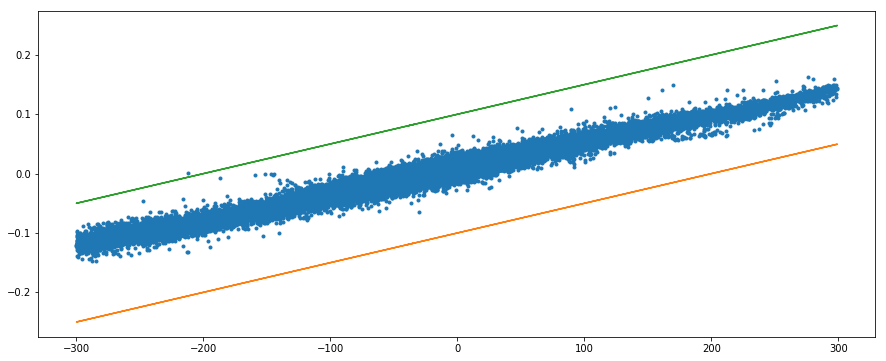

In [13]:
L = 0.73
plt.figure(figsize=(15, 6))
# plt.plot(data.steering_status[~idx], np.arctan(data.omega_yaw[~idx] * L / data.v[~idx]), '.', alpha = 0.2)
plt.plot(data.steering_status[idx], np.arctan(data.omega_yaw[idx] * L / data.v[idx]), '.')
plt.plot(data.steering_status[idx], data.steering_status[idx] * 0.0005-0.1)
plt.plot(data.steering_status[idx], data.steering_status[idx] * 0.0005+0.1);
# plt.plot(data.steering_status[idx2], np.arctan(data.omega_yaw[idx2] * L / data.v[idx2]), '.', alpha=0.2)
# plt.plot(data.steering_status[idx3], np.arctan(data.omega_yaw[idx3] * L / data.v[idx3]), '.', alpha=0.2)

In [14]:
data2 = data[idx].copy()
data2 = data2.reset_index(drop=True)

# 2. Seperate data as 100 batches of equal size (sorted by time)

In [15]:
n_batch = 100
batch_size = len(data2) // n_batch + 1
x = data2.steering_status
y = np.arctan(data2.omega_yaw * L / data2.v)
X = np.c_[np.ones(len(x)), x]

In [16]:
Res = []
for i in range(n_batch):
    X_tmp = X[i*batch_size: (i+1)*batch_size]
    y_tmp = y[i*batch_size: (i+1)*batch_size]
    para_tmp = la.inv(X_tmp.T @ X_tmp) @ X_tmp.T @ y_tmp
    sig_tmp = rmse(X_tmp @ para_tmp, y_tmp)
#     para_se_tmp = np.sqrt(np.diag(la.inv(X_tmp.T @ X_tmp) * sig2_tmp))
#     ss = para_tmp / para_se_tmp
    Res.append((*para_tmp, sig_tmp))

In [17]:
df_paras = pd.DataFrame(Res, columns = ['Int_', 'Coef_', 'Sig_'])

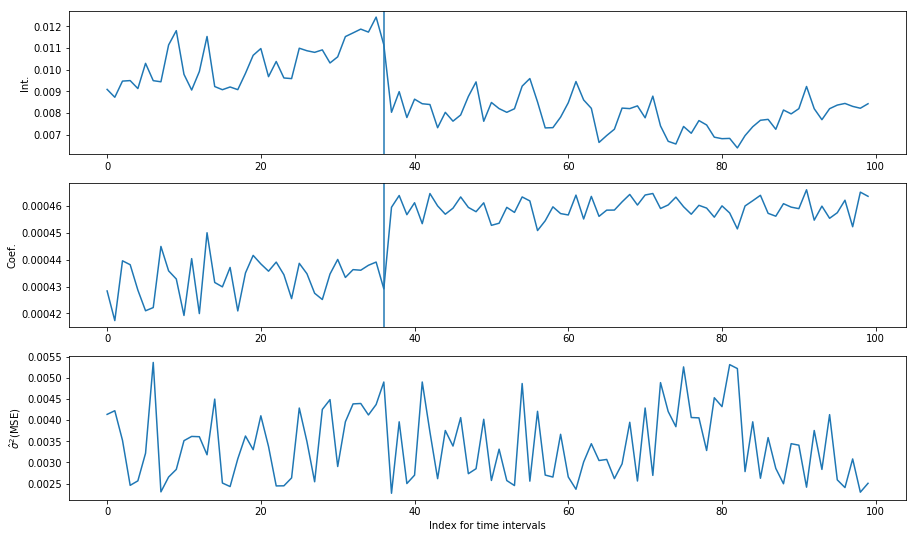

In [18]:
# left: +; right: -
plt.figure(figsize=(15, 9))
plt.subplot(311)
plt.plot(df_paras.Int_)
plt.axvline(36)
plt.ylabel('Int.')
plt.subplot(312)
plt.plot(df_paras.Coef_)
plt.axvline(36)
plt.ylabel('Coef.')
plt.subplot(313)
plt.plot(df_paras.Sig_)
plt.ylabel(r'$\hat\sigma^2$(MSE)')
plt.xlabel('Index for time intervals');

In [56]:
def plot_int(i):
    """
    plot scatter plot for the ith time interval
    """
    
    idx = np.arange(i*batch_size, (i+1)*batch_size)
    time1 = time.strftime("%Y/%m/%d", time.localtime(data2.loc[idx[0]].time1))
    time2 = time.strftime("%Y/%m/%d", time.localtime(data2.loc[idx[-1]].time1))
    print('Fitting data from', time1, 'to', time2)
#     plt.figure(figsize=(15, 6))
    plt.plot(data2.steering_status[idx], np.arctan(data2.omega_yaw[idx] * L / data2.v[idx]), '.')
    plt.plot(data2.steering_status[idx], data2.steering_status[idx]*df_paras.Coef_[i]+df_paras.Int_[i])
#     plt.plot(data2.steering_status[idx], np.arctan(data2.omega_yaw[idx] * L / data2.v[idx]), '.')

Fitting data from 2019/04/12 to 2019/04/16
Fitting data from 2019/04/16 to 2019/04/17


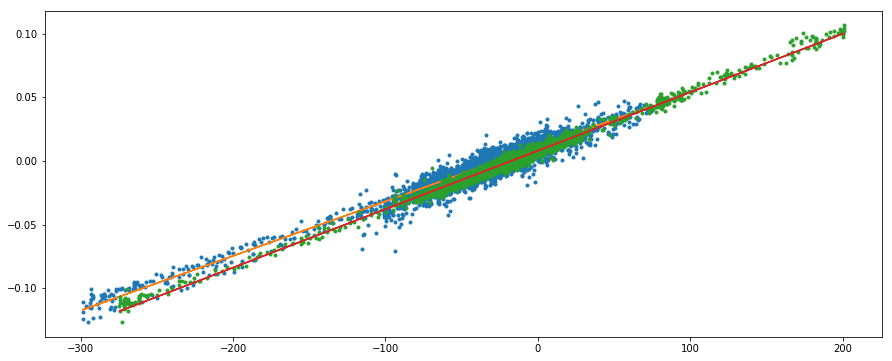

In [57]:
plt.figure(figsize=(15,6))
plot_int(36)
plot_int(37)
plt.show()

# Seperate by bag_name as 113 batches (bag_size > 500)

In [23]:
bn_count = dict(c.Counter(data2.bag_name1))
from_bn_2_size = lambda x: bn_count[x]
bag_size = np.array(list(map(from_bn_2_size, data2.bag_name1)))


data3 = data2[bag_size>500].copy()
data3 = data3.reset_index(drop=True)
bns = list(c.Counter(data3.bag_name1))

In [24]:
x2 = data3.steering_status
y2 = np.arctan(data3.omega_yaw * L / data3.v)
X2 = np.c_[np.ones(len(x2)), x2]


Res2 = []
for bn_ in bns:
    idx_tmp = (data3.bag_name1 == bn_)
    X_tmp = X2[idx_tmp]
    y_tmp = y2[idx_tmp]
    para_tmp = la.inv(X_tmp.T @ X_tmp) @ X_tmp.T @ y_tmp
    sig_tmp = rmse(X_tmp @ para_tmp, y_tmp)
#     para_se_tmp = np.sqrt(np.diag(la.inv(X_tmp.T @ X_tmp) * sig2_tmp))
#     ss = para_tmp / para_se_tmp
    Res2.append((bn_, *para_tmp, sig_tmp))

In [26]:
df_paras2 = pd.DataFrame(Res2, columns = ['bag_name', 'Int_', 'Coef_', 'Sig_'])

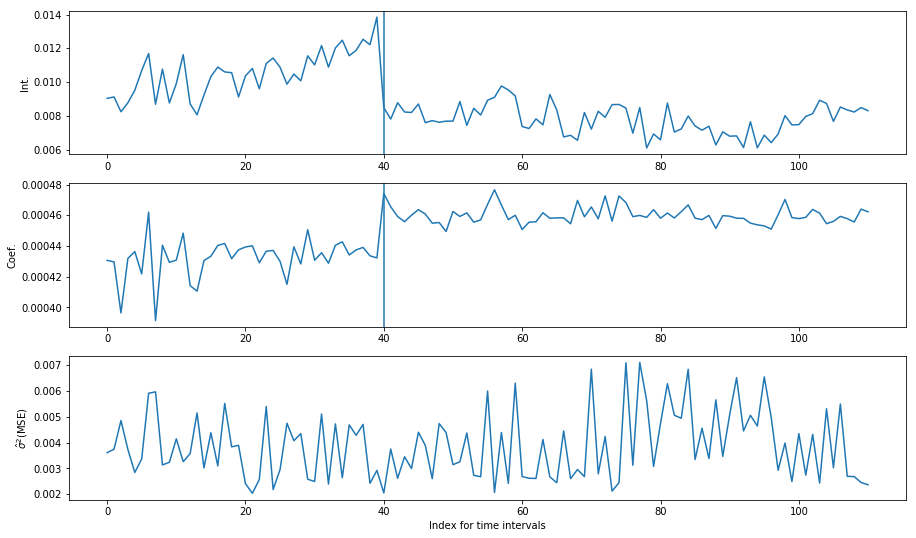

In [27]:
# left: +; right: -
plt.figure(figsize=(15, 9))
plt.subplot(311)
plt.plot(df_paras2.Int_)
plt.axvline(40)
plt.ylabel('Int.')
plt.subplot(312)
plt.plot(df_paras2.Coef_)
plt.axvline(40)
plt.ylabel('Coef.')
plt.subplot(313)
plt.plot(df_paras2.Sig_)
plt.ylabel(r'$\hat\sigma^2$(MSE)')
plt.xlabel('Index for time intervals');

+ #### Basic scheme

$$
\delta = ax+b+\epsilon,\qquad \epsilon \sim N(0, \sigma^2)
$$

where $\delta$ is the __front wheel steering angle__ (derived from formula $\delta = \arctan(\frac{\omega_{yaw}L}{v_{x}})$) and $x$ is __steering_status__

+ #### BLR scheme

$$
\delta = ax+b+\epsilon,\qquad \epsilon \sim N(0, \sigma^2),\ a\sim N(\mu_a, \sigma^2_a),\ b\sim N(\mu_b, \sigma^2_b)
$$

use the distribution of $a, b$ to identify outliers of coefficients and intercepts.

# 3. Stationarity test (check if there is time decay using stationarity test)

#### Stationarity test:

+ KPSS test:

Null Hypothesis: the process is trend-stationary

Alternative Hypothesis: the process has a unit root (this is how the authors of the test defined the alternative in their original 1992 paper)

+ ADF test:

Null Hypothesis: the process has a unit-root ("difference stationary") (not stationary)

Alternative Hypothesis: the process has no unit root. It can mean either that the process is stationary, or trend stationary, depending on which version of the ADF test is used

In [28]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [30]:
print('****Int_:****\n', testStationarity(df_paras.Int_), '\n\n', '****Coef_:****\n', testStationarity(df_paras.Coef_))

****Int_:****
 Test Statistic                 -3.021156
p-value                         0.032965
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64 

 ****Coef_:****
 Test Statistic                 -1.254646
p-value                         0.649658
#Lags Used                      4.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [31]:
print('****Int_:****\n', testStationarity(df_paras2.Int_), '\n\n', '****Coef_:****\n', testStationarity(df_paras2.Coef_))

****Int_:****
 Test Statistic                  -2.492904
p-value                          0.117210
#Lags Used                       1.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64 

 ****Coef_:****
 Test Statistic                  -2.456354
p-value                          0.126458
#Lags Used                       3.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


# 4. EDA (scatterplot and kde for paras)

In [32]:
from sklearn.preprocessing import scale

In [33]:
# scaled betas
Betas = scale(df_paras[['Int_', 'Coef_']])

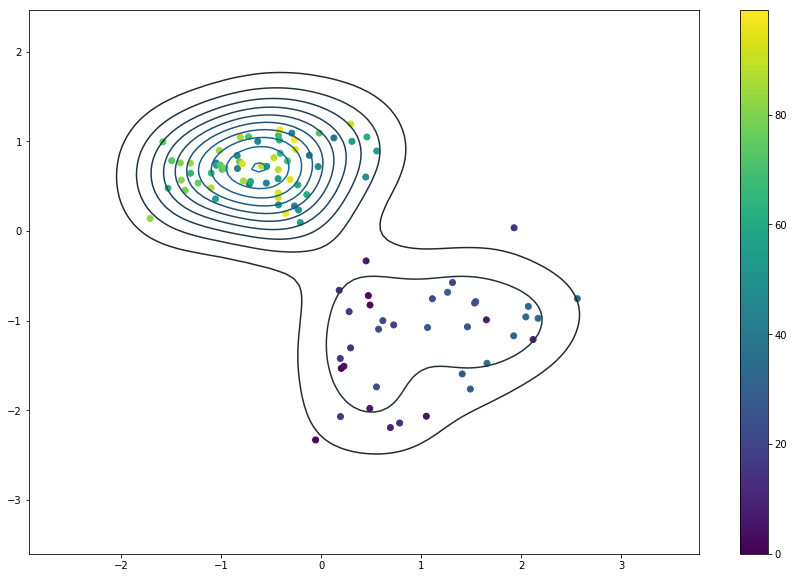

In [53]:
# plot_gmm(GMM, scale(Betas))
plt.figure(figsize=(15,10))
plt.scatter(*Betas.T, c=df_paras.index.values)
# colored by index
sns.kdeplot(*Betas.T)
plt.colorbar()
plt.show()

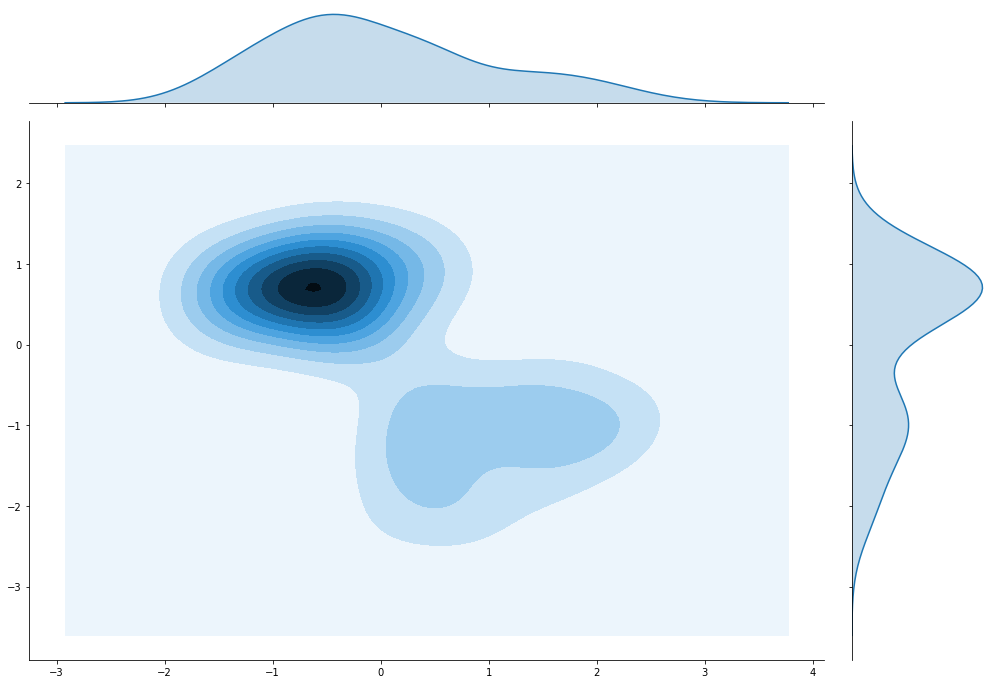

In [35]:
p1 = sns.jointplot(*Betas.T, kind = 'kde')
p1.fig.set_size_inches(15, 10)

Looks like the data might be from 2 different distributions. Then we might want to test whether the claim is true and also model the mixture model if so.

# 5. Hotelling's $T^2$ test and GMM

+ ### Hypothesis testing

In [36]:
import spm1d # T^2 test

In [37]:
# Hotelling's T2 test
T2 = spm1d.stats.hotellings2(Betas[:37], Betas[37:])
T2i = T2.inference(0.05)
T2i

SPM{T2} (0D) inference
   SPM.z        :  993.21869
   SPM.df       :  (2.0, 98.0)
Inference:
   SPM.alpha    :  0.050
   SPM.zstar    :  6.24409
   SPM.h0reject :  True
   SPM.p        :  0.00000


We reject the Hull hypothesis that the data (index from 0 to 36 and from 37 to 99) are from the same bivariate normal distribution at significance level fo 5%.

+ ### GMM

In [38]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(15,10))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [39]:
GMM = GaussianMixture(n_components=2)
GMM.fit(Betas)
labels = GMM.predict(Betas)

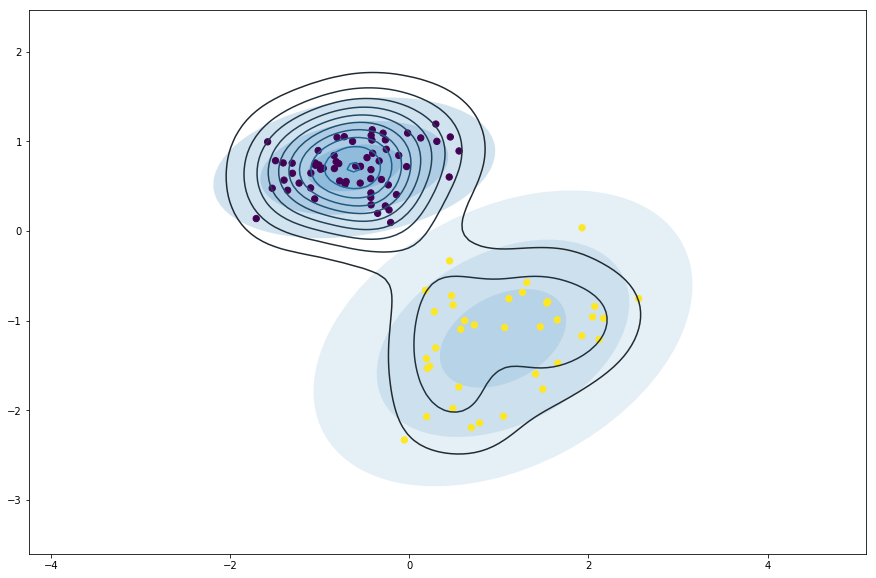

In [52]:
plot_gmm(GMM, Betas)
sns.kdeplot(*Betas.T)
plt.show()

# 6. Bayesian Model for outlier detection (using credible interval, posterior predictive distribution)

+ #### Basic scheme (OLS)

$$
\delta = ax+b+\epsilon,\qquad \epsilon \sim N(0, \sigma^2)
$$

where $\delta$ is the __front wheel steering angle__ (derived from formula $\delta = \arctan(\frac{\omega_{yaw}L}{v_{x}})$), $x$ is __steering_status__, $\omega_{yaw}$ is the angular velocity and $v_x$ is __velo_robot_x__

+ #### Bayesian Linear Regression (BLR) scheme

$$
\delta = ax+b+\epsilon,\qquad \epsilon \sim N(0, \sigma^2),\ a\sim N(\mu_a, \sigma^2_a),\ b\sim N(\mu_b, \sigma^2_b)
$$

use the distribution of $a, b$ to identify outliers of coefficients and intercepts.

__Or__ using another parametrization, we have

$$
\delta = \tilde X\beta+\epsilon
$$

where $\tilde X=[\mathbf 1, x]$, $\beta = (b, a)^T$, $\epsilon\sim N(0,\sigma^2)$, with conjugate priors (normal-gamma conjugate scheme)

$$
\beta\sim N(\mu_0, \Lambda_0^{-1}),\qquad \phi=(\sigma^2)^{-1}\sim Gamma(a_0,b_0)
$$


Then the posterior distribution of parameters given observed data can de induced by

$$
\begin{split}
p(\beta, \phi| X, y) &\propto p(\beta, \phi)p(y|\beta, \phi, X)\\
&\propto p(\beta| \phi)p(\phi)p(y|\beta, \phi, X)
\end{split}
$$

The parameters for posterior distribution are as follows:

$$
\begin{split}
\Lambda_n &= X^TX+ \Lambda_0\\
\mu_n &= \Lambda_n^{-1}(X^TX\hat\beta_{ols}+\Lambda_0\mu_0)\\
a_n &= a_0+\frac{n}{2}\\
b_n &= b_0+\frac{y^Ty+\mu_0^T\Lambda_0\mu_0-\mu_n^T\Lambda_n\mu_n}{2}
\end{split}
$$

In [41]:
from scipy.stats import gamma
from scipy.stats import multivariate_normal

from previous analysis, we know 'something' happened at arount 4/12 making the slope ($a$) and bias ($b$) from two different distribution. Thus, here we only take the most recent data and display a demo of how the BLR procedure would be to identify outliers

In [42]:
X_new = X[37*batch_size:]
y_new = y[37*batch_size:]

In [43]:
# Unit information prior
phi0 = 50000
n = len(X_new)
Lam0 = n*phi0*la.inv(X_new.T @ X_new)
beta_ols = la.inv(X_new.T @ X_new) @ X_new.T @ y_new
a0 = 1/2
b0 = 1/2 /phi0
mu0 = beta_ols

# Posterior parameters
mu_n = la.inv(X_new.T @ X_new + Lam0) @ (Lam0 @ mu0 + X_new.T @ X_new @ beta_ols)
Lam_n = X_new.T @ X_new + Lam0
a_n = a0+n/2
b_n = b0+1/2*(y_new.T @ y_new + mu0.T @ Lam0 @ mu0 - mu_n.T @ Lam_n @ mu_n)

In [44]:
from scipy.stats import norm, chi2

def plot_cov_ellipse(cov, pos, q=None, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : (2, 2) array
            Covariance matrix.
        q : float, optional
            Confidence level, should be in (0, 1)
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    
    if q is not None:
        q = np.asarray(q)
    elif nstd is not None:
        q = 2 * norm.cdf(nstd) - 1
    else:
        raise ValueError('One of `q` and `nstd` should be specified.')
    r2 = chi2.ppf(q, 2)
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1,0]))

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(vals * r2) # sqrt(lambda_i) * r
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

### Using credible region (HPD) to detect outliers, including covariance structure

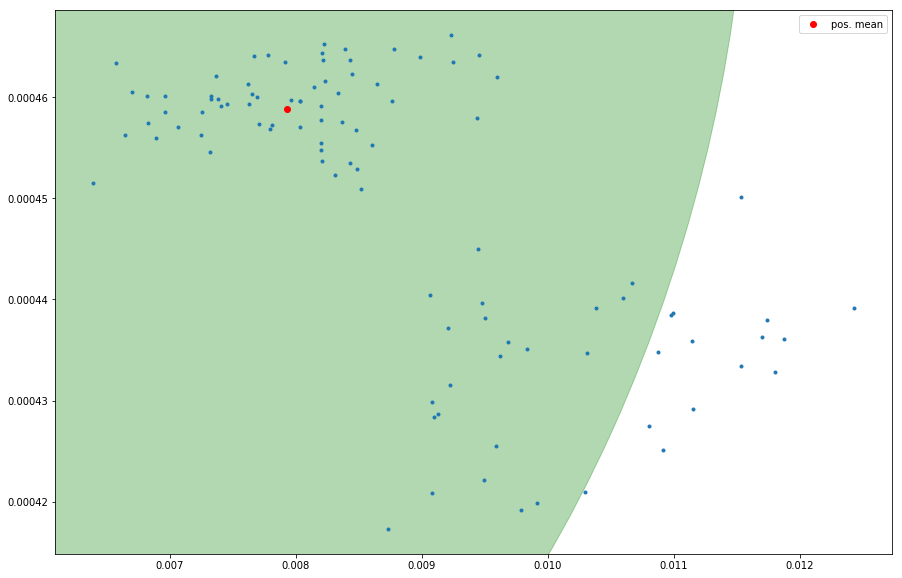

In [45]:
if __name__ == '__main__':
    plt.figure(figsize=(15,10))
    plt.plot(*df_paras[['Int_', 'Coef_']].values.T, '.')
    plt.plot(*mu_n, 'ro', label = 'pos. mean')
    # Plot a transparent 2 standard deviation covariance ellipse
    plot_cov_ellipse(cov=la.inv(Lam_n), pos=mu_n, q = 0.95, alpha=0.3, color='green')
    plt.legend();

### Use credible intervals (marginal distribution) to detect outliers, ignoring covariance structure

In [46]:
upr = mu_n + norm.ppf(0.975) * np.sqrt(np.diag(la.inv(Lam_n)))
lwr = mu_n - norm.ppf(0.975) * np.sqrt(np.diag(la.inv(Lam_n)))

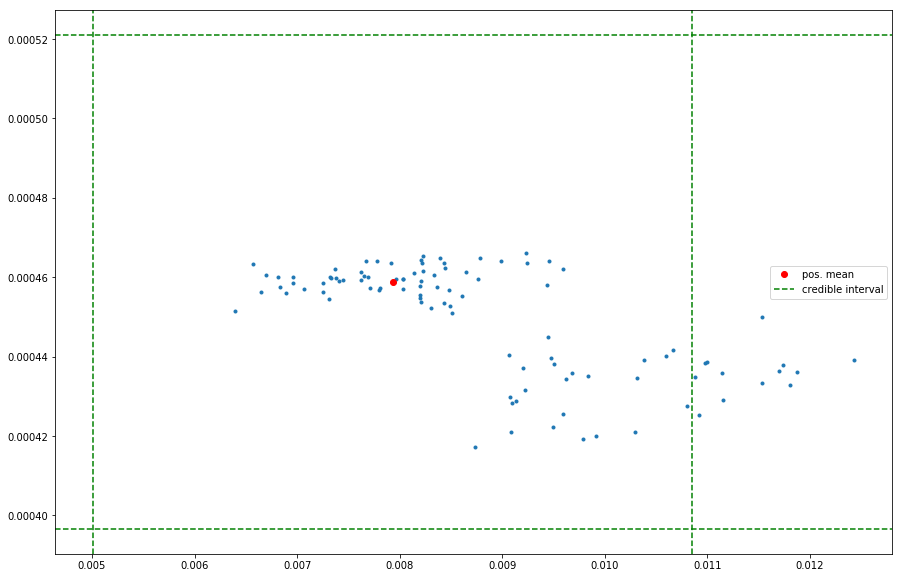

In [47]:
if __name__ == '__main__':
    plt.figure(figsize=(15,10))
    plt.plot(*df_paras[['Int_', 'Coef_']].values.T, '.')
    plt.plot(*mu_n, 'ro', label = 'pos. mean')
    plt.axvline(upr[0], linestyle = '--', color='g', label = 'credible interval')
    plt.axvline(lwr[0], linestyle = '--', color='g')
    plt.axhline(upr[1], linestyle = '--', color='g')
    plt.axhline(lwr[1], linestyle = '--', color='g')
    plt.legend();